In [19]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

SyntaxError: invalid syntax (2150869044.py, line 4)

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="5unIGzOSuGWcjTn2xDoT")
project = rf.workspace("new-workspace-7ly0p").project("durian-diseases")
dataset = project.version(5).download("tensorflow")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Durian-Diseases-5 in tensorflow:: 100%|██████████| 424/424 [00:00<00:00, 688.16it/s]


In [21]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Durian-Diseases-5",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 918 files belonging to 3 classes.


In [13]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [22]:
class_names = dataset.class_names
class_names

['BinhThuong', 'ChayLa', 'DomLa']

In [23]:
len(dataset)

29

In [24]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 2 0 2 2 2 1 0 2 1 0 2 0 2 1 1 2 0 2 2 1 1 2 1 2 2 1 2 1 1 2]


In [25]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


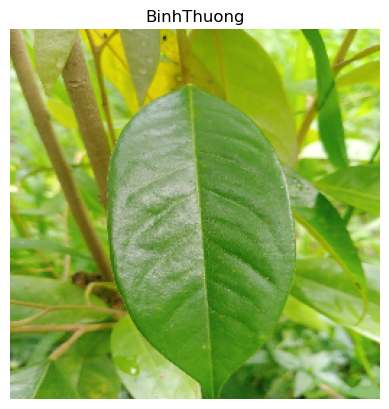

In [26]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

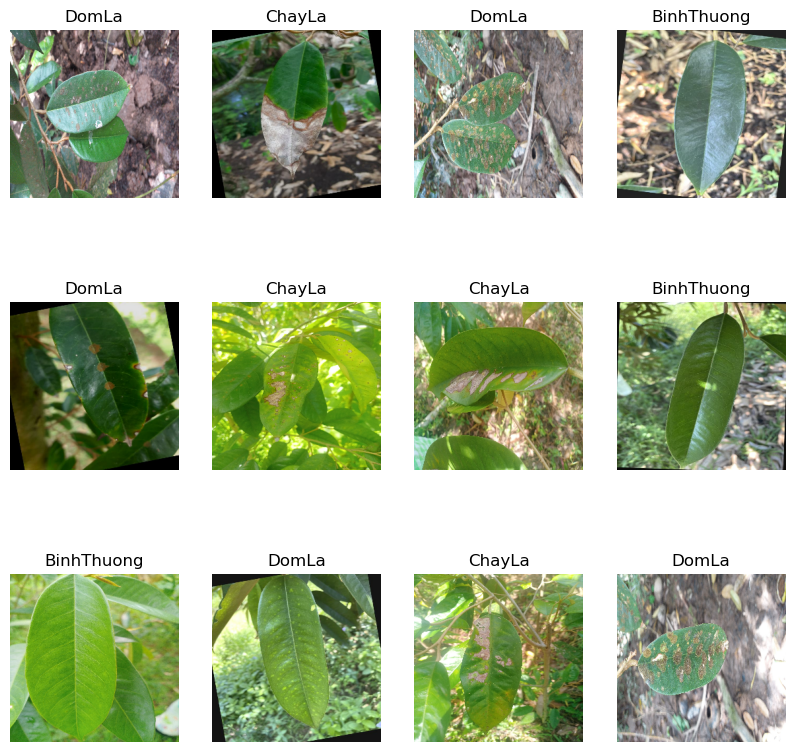

In [27]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [28]:
len(dataset)

29

In [29]:
train_size = 0.8
len(dataset)*train_size

23.200000000000003

In [30]:
train_ds= dataset.take(11)
len(train_ds)

11

In [31]:
test_ds = dataset.skip(11)
len(test_ds)

18

In [32]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [33]:
test_ds = test_ds.skip(1)

In [34]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds, test_ds

In [35]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [36]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [38]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [39]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
23/23 [==============================] - 86s 3s/step - loss: 1.0896 - accuracy: 0.4132 - val_loss: 1.0750 - val_accuracy: 0.4325
Epoch 2/50
23/23 [==============================] - 68s 3s/step - loss: 1.0732 - accuracy: 0.4325 - val_loss: 1.0578 - val_accuracy: 0.4325
Epoch 3/50
23/23 [==============================] - 68s 3s/step - loss: 1.0463 - accuracy: 0.4490 - val_loss: 1.0098 - val_accuracy: 0.4945
Epoch 4/50
23/23 [==============================] - 68s 3s/step - loss: 0.9123 - accuracy: 0.5785 - val_loss: 0.7496 - val_accuracy: 0.6846
Epoch 5/50
23/23 [==============================] - 69s 3s/step - loss: 0.7880 - accuracy: 0.6336 - val_loss: 0.7735 - val_accuracy: 0.6061
Epoch 6/50
23/23 [==============================] - 68s 3s/step - loss: 0.7596 - accuracy: 0.6763 - val_loss: 0.6063 - val_accuracy: 0.7369
Epoch 7/50
23/23 [==============================] - 65s 3s/step - loss: 0.6301 - accuracy: 0.7135 - val_loss: 0.5288 - val_accuracy: 0.7782
Epoch 8/50
23/23 [==

In [43]:
scores = model.evaluate(test_ds)

23/23 [==============================] - 9s 404ms/step - loss: 0.2390 - accuracy: 0.9050


In [44]:
scores

[0.23898248374462128, 0.9049586653709412]

In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 23}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

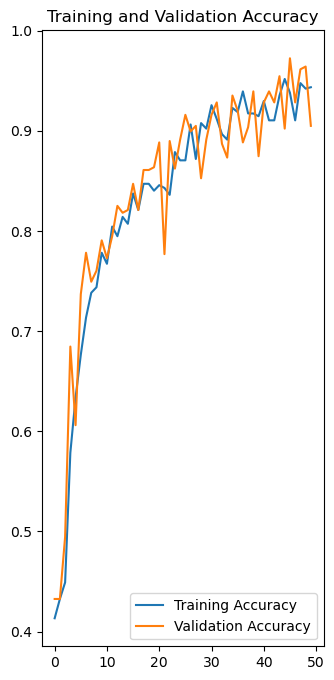

In [49]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
first image's actual label ChayLa
1/1 [==============================] - 1s 1s/step
predicted label: ChayLa


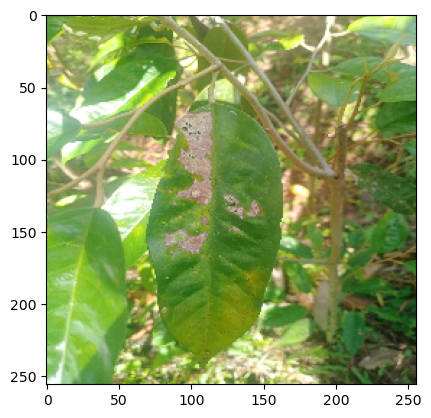

In [50]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
        
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print("first image's actual label", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 66ms/step


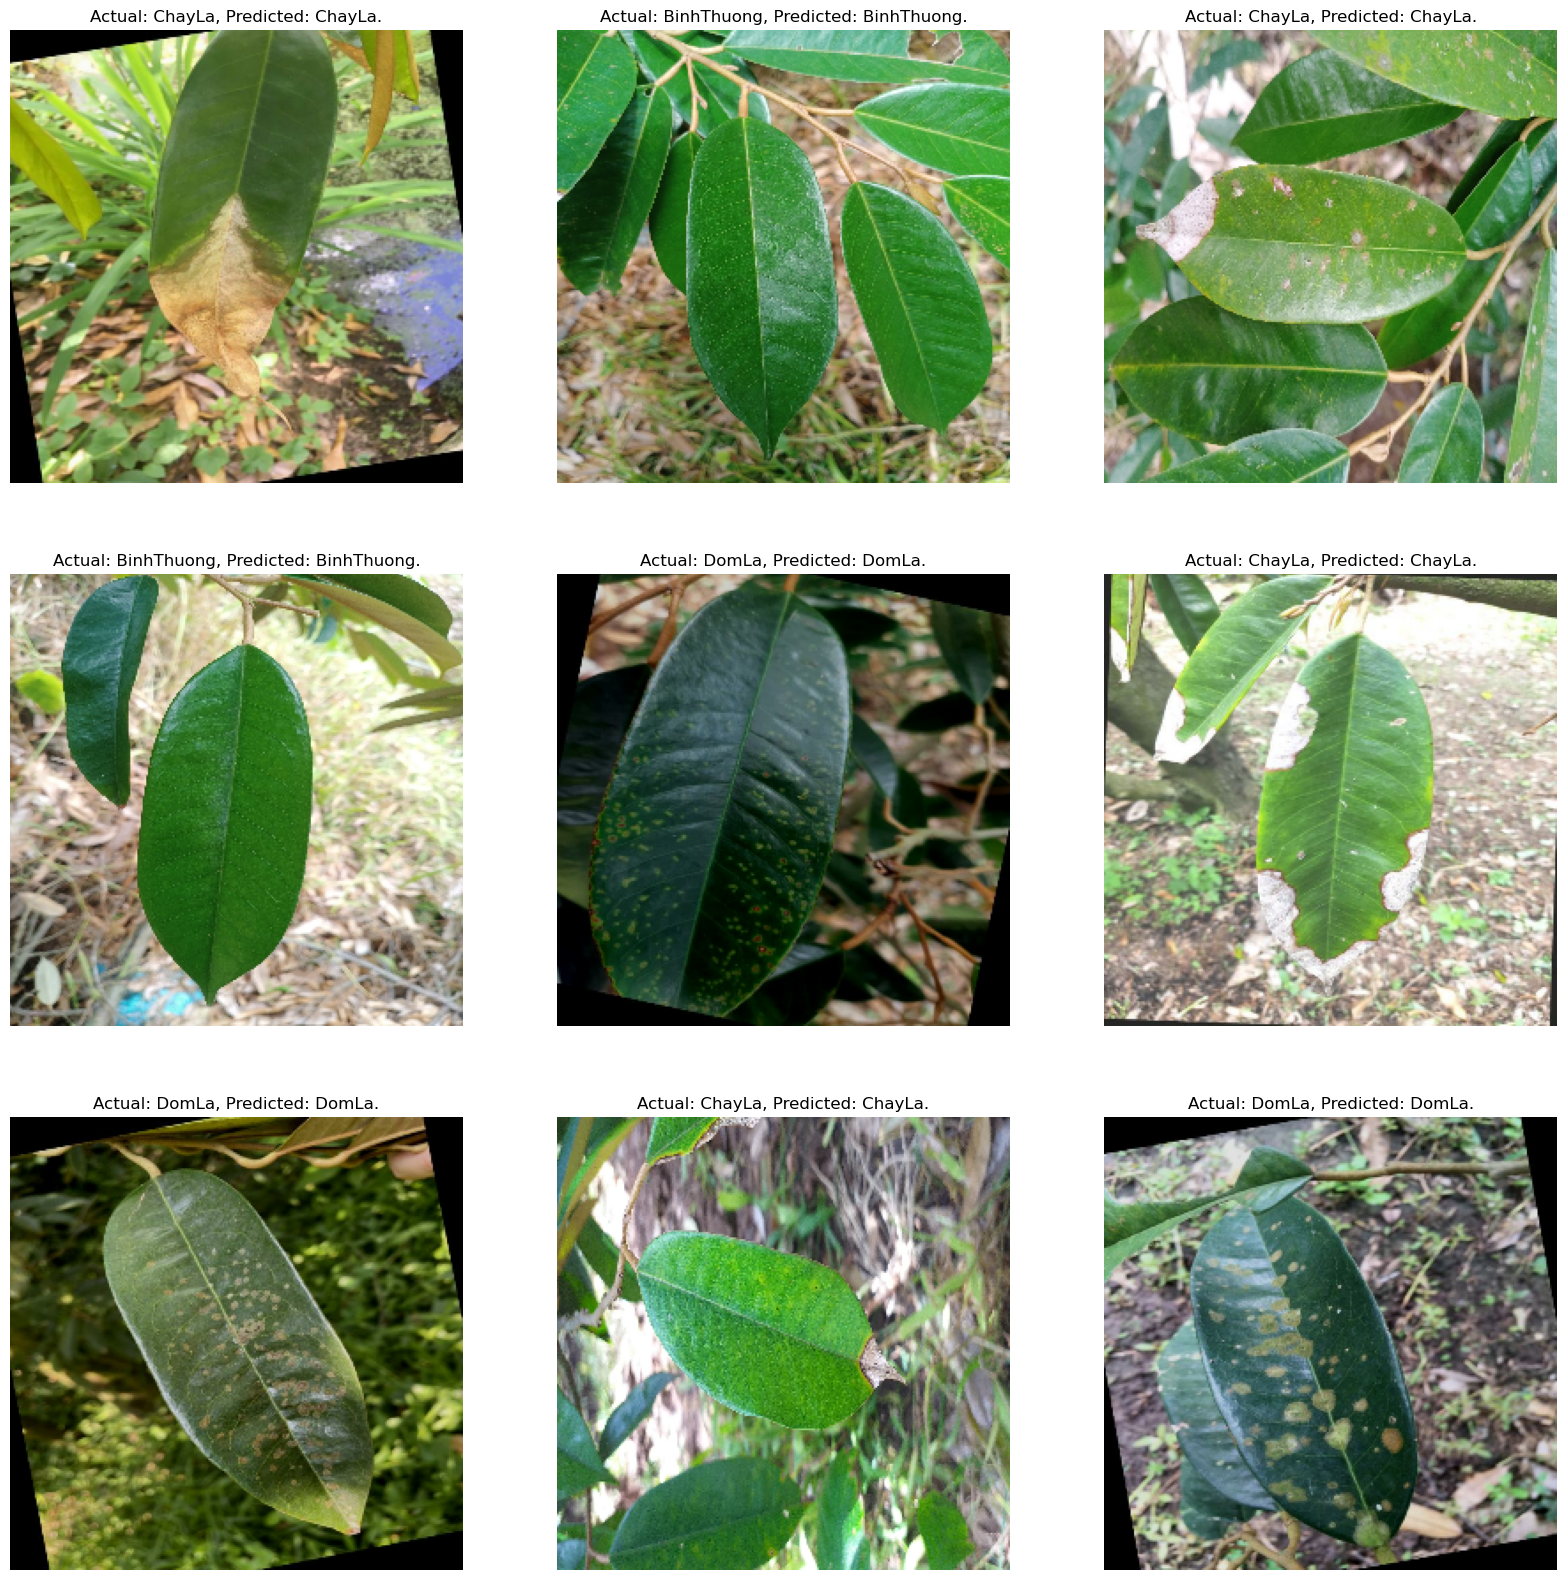

In [52]:
plt.figure(figsize=(20,20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predict_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, Predicted: {predict_class}.")
        plt.axis("off")

In [53]:
model_version= 3
model.save(f"../Modelss/{model_version}")

INFO:tensorflow:Assets written to: ../Modelss/3\assets


INFO:tensorflow:Assets written to: ../Modelss/3\assets
